# Toxicity Prediction Project
Final Project - Applied Case Studies of Machine Learning and Deep Learning in Key Areas 2

Bulloni Dyuman, Ippolito Manuel, Loddo Fabio - D3A

Import the required Python libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np
import random
from tabulate import tabulate

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# File handling
import os
from pathlib import Path
import datetime

# RDKit modules
import rdkit as rd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

# Deep Purpose modules
from DeepPurpose import *
from DeepPurpose import ProteinPred as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
from DeepPurpose import CompoundPred, dataset, utils

# Modeling
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, confusion_matrix, balanced_accuracy_score

# Warnings
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import Dataset, DataLoader
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # use GPU if available

Settings

In [2]:
# Set seed value
SEED_VALUE = 124 #122 123 124, as used in MoleculeNet

# Set torch settings
torch.manual_seed(SEED_VALUE)
torch.cuda.manual_seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
random.seed(SEED_VALUE)
#deeppurpose.utils.seed_everything(SEED_VALUE)
torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic=True

Constants

In [3]:
# Number of bits for morgan fingerprints
MORGAN_BITS = 4096

# Number of radius for morgan fingerprints
MORGAN_RADIUS = 2

## Data Exploration

Import the data

In [4]:
# Define path to the Data folder
DATA_PATH: Path = Path(os.getcwd() + "/Data")
DATA_PATH

WindowsPath('c:/Users/manue/SUPSI/Sixth Semester User/Bio Grasso/Final project/toxicity_prediction/Data')

In [5]:
# Import the clintox dataset
# Clintox dataset contains clinical toxicology data
clintox = pd.read_csv(DATA_PATH / "clintox.csv")
clintox_task = ['CT_TOX']
clintox.head()

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0
3,[H]/[NH+]=C(/C1=CC(=O)/C(=C\C=c2ccc(=C([NH3+])...,1,0
4,[H]/[NH+]=C(\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(...,1,0


In [6]:
# Import the tox21 dataset
# Tox21 dataset contains in vitro toxicology data 
tox21 = pd.read_csv(DATA_PATH / "tox21.csv")
tox21_tasks = ['NR-AR', 'NR-Aromatase', 'NR-PPAR-gamma', 'SR-HSE', 
               'NR-AR-LBD', 'NR-ER', 'SR-ARE', 'SR-MMP',
               'NR-AhR', 'NR-ER-LBD', 'SR-ATAD5', 'SR-p53']
tox21.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


In vivo data (that in the reference papers come from the dataset RTECS by Biovia) are not available  publicly and require a fee or a subscription to be provided, so we will work on clinical and in vitro data for this project.

### Plot data

#### Clintox dataset

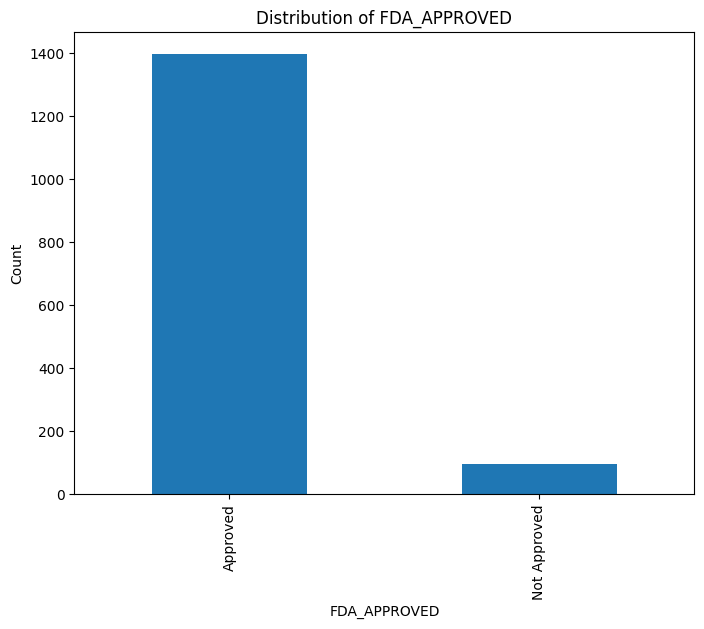

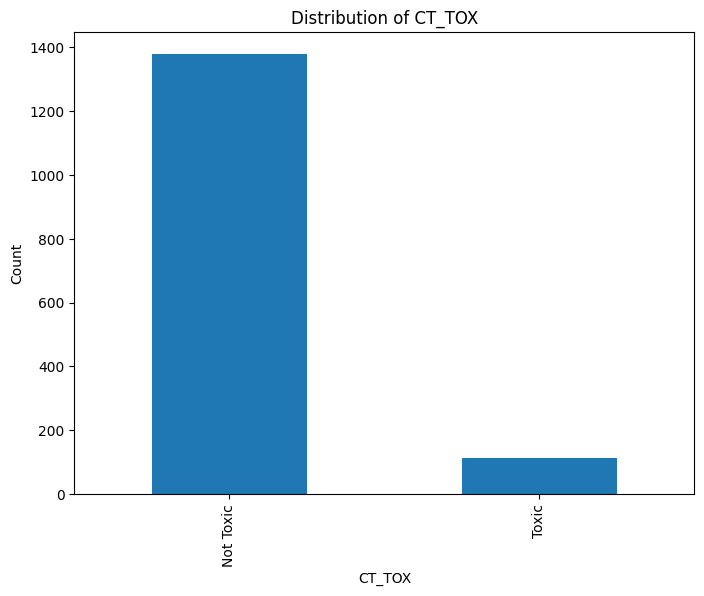

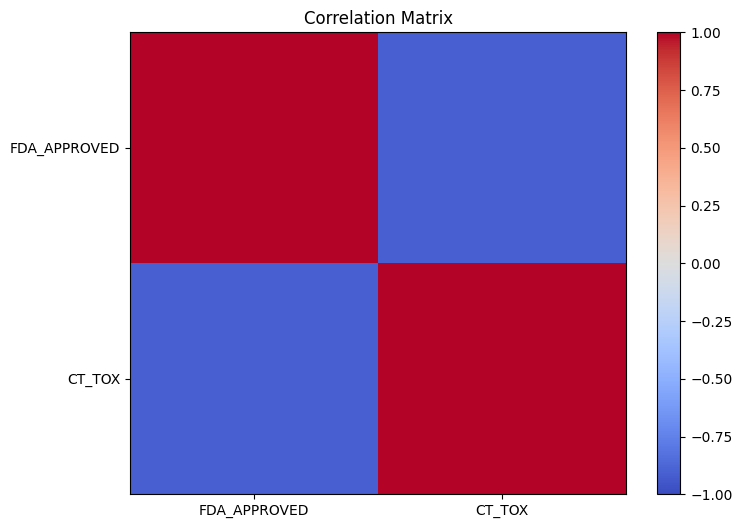

In [7]:
# Plot the distribution of FDA_APPROVED
plt.figure(figsize=(8, 6))
clintox['FDA_APPROVED'].value_counts().plot(kind='bar')
plt.title('Distribution of FDA_APPROVED')
plt.xlabel('FDA_APPROVED')
plt.ylabel('Count')
plt.xticks([0, 1], ['Approved', 'Not Approved'])
plt.show()

# Plot the distribution of CT_TOX
plt.figure(figsize=(8, 6))
clintox['CT_TOX'].value_counts().plot(kind='bar')
plt.title('Distribution of CT_TOX')
plt.xlabel('CT_TOX')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Toxic', 'Toxic'])
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
correlation_matrix = clintox[['FDA_APPROVED', 'CT_TOX']].corr()
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.colorbar()
plt.xticks([0, 1], ['FDA_APPROVED', 'CT_TOX'])
plt.yticks([0, 1], ['FDA_APPROVED', 'CT_TOX'])
plt.title('Correlation Matrix')
plt.show()

From the distributions of CT_TOX we can see that the dataset is unbalanced, as there are way more non toxic drugs than toxic drugs in it. The same for FDA_APPROVED, we have way more FDA approved drugs than non-FDA-approved drugs in the dataset.

It seems there is a net inverse correlation between FDA_APPROVED and CT_TOX. IT makes sense that FDA approved drugs are not toxic.

#### Tox21 dataset

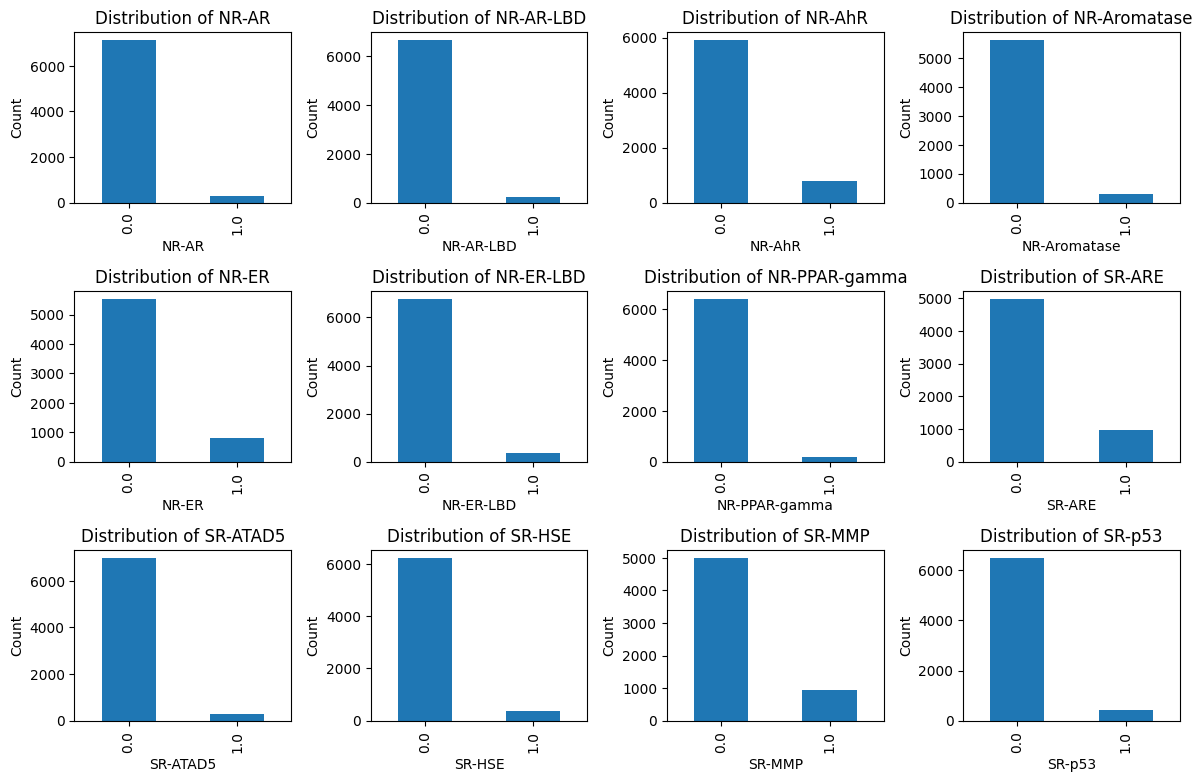

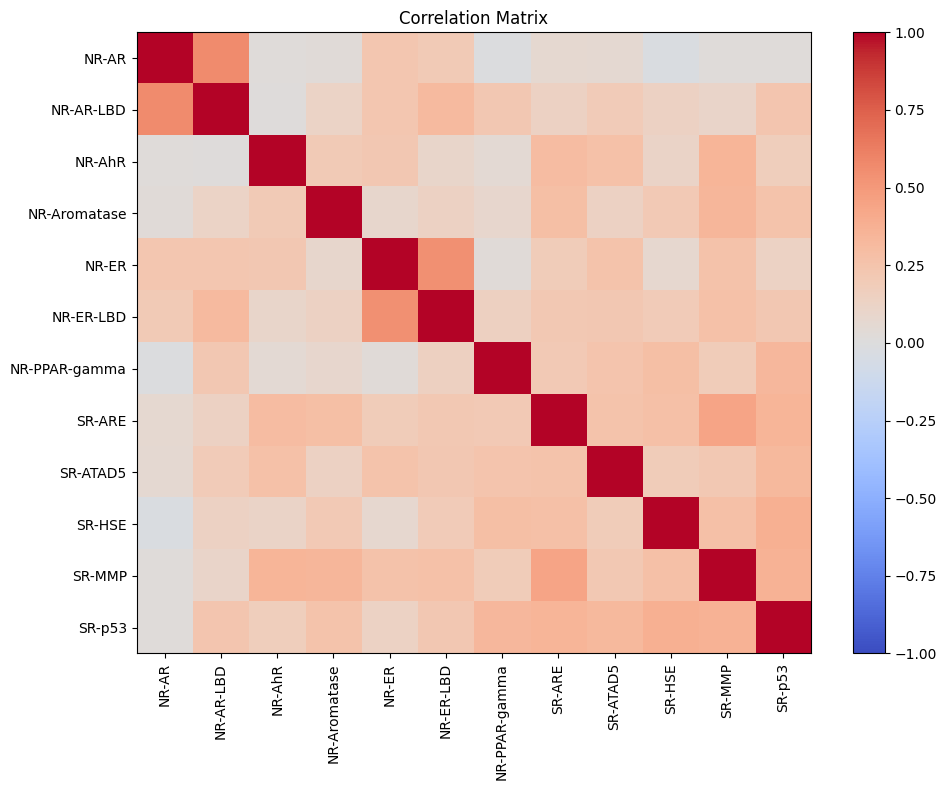

In [8]:
# Plot the distribution of each target column
plt.figure(figsize=(12, 10))
target_columns = tox21.columns[:-2]  # Exclude 'mol_id' and 'smiles' columns
for i, col in enumerate(target_columns):
    plt.subplot(4, 4, i+1)
    tox21[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = tox21.iloc[:, :-2].corr()
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.colorbar()
plt.xticks(range(len(target_columns)), target_columns, rotation=90)
plt.yticks(range(len(target_columns)), target_columns)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

All the features in Tox21 are metrics of toxicity of drugs. They follow the same distribution of CT_TOX seen in Clintox dataset.
Also in this case thus we have way more non-toxic drugs than toxic drugs in the dataset.

From the correlation matrix we can see that there is a small positive correlation between most of the toxicity metrics, but just 2 couples of 2 features have a quite high correlation coefficient between them. These are NR-AR with NR-AR-LBD, and NR-ER with NR-ER-LBD.
After having searched a bit of information on these features, we found that they are all nuclear receptor signaling bioassays results, and the couples of features have very similar meaning, so the correlation is of course there.

## Data Pre-Processing

### Process data

In [9]:
# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES)
def remove_non_valid_rows(df: pd.DataFrame) -> pd.DataFrame:
    mol_list = []
    valid_rows = []
    for i, row in df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        if mol is not None:
            mol_list.append(mol)
            valid_rows.append(row)

    df = pd.DataFrame(valid_rows)
    return df

#### Clintox dataset

In [10]:
# Clean the database, check for redundancy and remove duplicates

# Remove duplicated rows
print('Clintox dataset dimensions with duplicates:', clintox.shape)
clintox.drop_duplicates(inplace=True) # Drop duplicated rows
print('Clintox dataset dimensions without duplicates:', clintox.shape)

# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES, null SMILES, duplicated SMILES)
clintox = remove_non_valid_rows(clintox) # remove rows with non valid SMILES
clintox.drop_duplicates(subset = ['smiles'], inplace=True) # Remove duplicated canonical SMILES
clintox.dropna(subset=['smiles'], inplace=True) # Remove null SMILES
print('Clintox dataset dimensions without non valid rows:', clintox.shape)
clintox.head(3)

Clintox dataset dimensions with duplicates: (1491, 3)
Clintox dataset dimensions without duplicates: (1484, 3)


[15:46:13] Explicit valence for atom # 0 N, 5, is greater than permitted
[15:46:13] Can't kekulize mol.  Unkekulized atoms: 9
[15:46:13] Explicit valence for atom # 10 N, 4, is greater than permitted
[15:46:13] Explicit valence for atom # 10 N, 4, is greater than permitted
[15:46:13] Can't kekulize mol.  Unkekulized atoms: 4
[15:46:13] Can't kekulize mol.  Unkekulized atoms: 4


Clintox dataset dimensions without non valid rows: (1478, 3)


,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0


In [11]:
# Check for null values
clintox.isna().sum()

smiles          0
FDA_APPROVED    0
CT_TOX          0
dtype: int64

#### Tox21 dataset

In [12]:
# Clean the database, check for redundancy and remove duplicates

# Remove duplicated rows
print('Tox21 dataset dimensions with duplicates:', tox21.shape)
tox21.drop_duplicates(inplace=True) # Drop duplicated rows
print('Tox21 dataset dimensions without duplicates:', tox21.shape)

# Remove non valid rows (SMILES that cannot be converted to Canonical SMILES, null SMILES, duplicated SMILES)
tox21 = remove_non_valid_rows(tox21) # remove rows with non valid SMILES
tox21.drop_duplicates(subset = ['smiles'], inplace=True) # Remove duplicated canonical SMILES
tox21.dropna(subset=['smiles'], inplace=True) # Remove null SMILES
print('Tox21 dataset dimensions without non valid rows:', tox21.shape)
tox21.head(3)

Tox21 dataset dimensions with duplicates: (8014, 14)
Tox21 dataset dimensions without duplicates: (8014, 14)


[15:46:13] WARNING: not removing hydrogen atom without neighbors


Tox21 dataset dimensions without non valid rows: (7831, 14)


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...


In [13]:
# Check for null values
tox21.isna().sum()

NR-AR             569
NR-AR-LBD        1083
NR-AhR           1299
NR-Aromatase     2030
NR-ER            1651
NR-ER-LBD         886
NR-PPAR-gamma    1395
SR-ARE           2026
SR-ATAD5          763
SR-HSE           1381
SR-MMP           2041
SR-p53           1072
mol_id              0
smiles              0
dtype: int64

Check what to do with all these null values
We have already removed all the rows with null SMILES

In [14]:
# Replace NA with -1 -- used to deal with missing labels, along with Binary Cross-Entropy loss
# Nulls are thus considered a third class
tox21 = tox21.fillna(-1)

In [15]:
# Check for null values
tox21.isna().sum()

NR-AR            0
NR-AR-LBD        0
NR-AhR           0
NR-Aromatase     0
NR-ER            0
NR-ER-LBD        0
NR-PPAR-gamma    0
SR-ARE           0
SR-ATAD5         0
SR-HSE           0
SR-MMP           0
SR-p53           0
mol_id           0
smiles           0
dtype: int64

### Train-test split
In the reference papers the split of data is provided, so we'll use their same splits in order to be able to compare our results with the state-of-the-art performances.

#### Clintox Dataset

In [16]:
### Method borrowed from MoleculeNet for random splits of 0.8 / 0.1 / 0.1, train / test / valid 
# Returns index of random train, test, valid datasets in array of [train,test,valid]
def split(dataset,
            seed=None,
            frac_train=.8,
            frac_valid=.1,
            frac_test=.1,
            log_every_n=None):
    """
    Splits internal compounds randomly into train/validation/test.
    """
    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)
    if not seed is None:
        np.random.seed(seed)
    num_datapoints = len(dataset)
    train_cutoff = int(frac_train * num_datapoints)
    valid_cutoff = int((frac_train + frac_valid) * num_datapoints)
    shuffled = np.random.permutation(range(num_datapoints))
    return (shuffled[:train_cutoff], shuffled[train_cutoff:valid_cutoff],
            shuffled[valid_cutoff:])

In [17]:
# Split the Clintox dataset into train-test-validation sets with ratios 0.8/0.1/0.1
train_indices, test_indices, valid_indices = split(clintox, frac_train=0.8, frac_valid=0.1, frac_test=0.1)  # Use random seed from MoleculeNet

clintox_train = clintox.iloc[train_indices]
clintox_test = clintox.iloc[test_indices]
clintox_val = clintox.iloc[valid_indices]

clintox_data = [clintox_train, clintox_test, clintox_val]


In [18]:
# Check the number of samples in each set
print("Total number of samples, train: " + str(clintox_data[0].shape[0]))
print("Total number of samples, test: " + str(clintox_data[1].shape[0]))
print("Total number of samples, valid: " + str(clintox_data[2].shape[0]))
print("Total number of samples, train+test+valid: " + str(clintox_data[0].shape[0] + 
                                                           clintox_data[1].shape[0] + 
                                                           clintox_data[2].shape[0]))

Total number of samples, train: 1182
Total number of samples, test: 148
Total number of samples, valid: 148
Total number of samples, train+test+valid: 1478


#### Tox21 Dataset

In [19]:
# Split the Tox21 dataset into train-test-validation sets with ratios 0.8/0.1/0.1
train_indices, test_indices, valid_indices = split(tox21, frac_train=0.8, frac_valid=0.1, frac_test=0.1)  # Use random seed from MoleculeNet

tox21_train = tox21.iloc[train_indices]
tox21_test = tox21.iloc[test_indices]
tox21_val = tox21.iloc[valid_indices]

tox21_data = [tox21_train, tox21_test, tox21_val]

In [20]:
# Check the number of samples in each set
print("Total number of samples, train: " + str(tox21_data[0].shape[0]))
print("Total number of samples, test: " + str(tox21_data[1].shape[0]))
print("Total number of samples, valid: " + str(tox21_data[2].shape[0]))
print("Total number of samples, train+test+valid: " + str(tox21_data[0].shape[0] + 
                                                           tox21_data[1].shape[0] + 
                                                           tox21_data[2].shape[0]))

Total number of samples, train: 6264
Total number of samples, test: 783
Total number of samples, valid: 784
Total number of samples, train+test+valid: 7831


## Modelling

### Using Clintox data

#### Construct Morgan fingerprints

In [21]:
# Save a copy of train-test-val splits before adding informations
clintox_df = []
clintox_df.append(clintox_data[0].copy())
clintox_df.append(clintox_data[1].copy())
clintox_df.append(clintox_data[2].copy())

In [22]:
# Check clintox_data
clintox_data[0].head(3)

,smiles,FDA_APPROVED,CT_TOX
755,CC(C)CN(C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H]2CC...,1,0
96,C1[C@H](C(=O)NO1)[NH3+],1,0
671,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,0,1


In [23]:
# Construct morgan fingerprints 
for i in range(len(clintox_data)):
    clintox_data[i]['mol'] = [rd.Chem.MolFromSmiles(x) for x in clintox_data[i]['smiles']]

    bi = [{} for _ in range(len(clintox_data[i]))]
    clintox_data[i]['morgan'] = [AllChem.GetMorganFingerprintAsBitVect(clintox_data[i].iloc[j]['mol'], MORGAN_RADIUS, nBits = MORGAN_BITS, bitInfo=bi[j]) 
                         for j in range(len(clintox_data[i]))]
    clintox_data[i]['bitInfo'] = bi

In [24]:
# Check clintox_data
clintox_data[0].head(3)

,smiles,FDA_APPROVED,CT_TOX,mol,morgan,bitInfo
755,CC(C)CN(C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H]2CC...,1,0,<rdkit.Chem.rdchem.Mol object at 0x0000029B89D...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{32: ((18, 2),), 117: ((15, 1),), 119: ((19, 1..."
96,C1[C@H](C(=O)NO1)[NH3+],1,0,<rdkit.Chem.rdchem.Mol object at 0x0000029B89D...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{656: ((5, 0),), 1124: ((6, 1),), 1380: ((2, 0..."
671,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,0,1,<rdkit.Chem.rdchem.Mol object at 0x0000029B89D...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","{45: ((21, 1),), 58: ((8, 2),), 204: ((27, 2),..."


In [25]:
# Split data into training, testing and valuidation sets
train_data = clintox_data[0]
test_data  = clintox_data[1]
valid_data = clintox_data[2]

#### Arrays for train / test / valid sets used for DNN 

In [26]:
# convert the RDKit explicit vectors into numpy arrays
x_train = []
for fp in train_data['morgan']:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    x_train.append(arr)
x_train = np.array(x_train)
x_train = x_train - 0.5

y_train = train_data[clintox_task].values


# convert the RDKit explicit vectors into numpy arrays
x_test = []
for fp in test_data['morgan']:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    x_test.append(arr)
x_test = np.array(x_test)
x_test = x_test - 0.5

y_test = test_data[clintox_task].values


# convert the RDKit explicit vectors into numpy arrays
x_valid = []
for fp in valid_data['morgan']:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    x_valid.append(arr)
x_valid = np.array(x_valid)
x_valid = x_valid - 0.5

y_valid = valid_data[clintox_task].values

In [27]:
# count the number of data points per class
N_train = np.sum(y_train >= 0, 0)
N_test  = np.sum(y_test >= 0, 0)
N_valid  = np.sum(y_valid >= 0, 0)

#### Reference model

In [28]:
# Parameters for the model 
train_epoch = 50 
batch = 512 

In [29]:
# convert data for pytorch
x_train_torch = x_train.astype(np.float32)
y_train_torch = y_train.astype(np.float32)

x_test_torch = x_test.astype(np.float32)
y_test_torch = y_test.astype(np.float32)

x_valid_torch = x_valid.astype(np.float32)
y_valid_torch = y_valid.astype(np.float32)

In [30]:
input_shape = x_train_torch.shape[1]
input_shape

4096

In [31]:
# Class for STDNN data
class STDNNData(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [32]:
training_set = STDNNData(x_train_torch, y_train_torch)
training_generator = DataLoader(training_set, batch_size=batch, shuffle=True)

testing_set = STDNNData(x_test_torch, y_test_torch)
testing_generator = DataLoader(testing_set, batch_size=len(testing_set), shuffle=False)

valid_set = STDNNData(x_valid_torch, y_valid_torch)
valid_generator = DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

In [33]:
# STDNN Model class
# For each task (1 only in ClinTox), creates 2 hidden layers 

class STDNN(torch.nn.Module):
    def __init__(self, input_shape, all_tasks):
        super(STDNN, self).__init__()

        self.hidden_3 = torch.nn.ModuleList([torch.nn.Linear(input_shape, 1024) for task in all_tasks])
        self.batchnorm_3 = torch.nn.ModuleList([torch.nn.BatchNorm1d(1024) for task in all_tasks])
       
        self.hidden_4 = torch.nn.ModuleList([torch.nn.Linear(1024, 512) for task in all_tasks])
        self.batchnorm_4 = torch.nn.ModuleList([torch.nn.BatchNorm1d(512) for task in all_tasks])
        
        self.output   = torch.nn.ModuleList([torch.nn.Linear(512, 1) for task in all_tasks])
        
        # function for leaky ReLU
        self.leakyReLU = torch.nn.LeakyReLU(0.05)

    def forward(self, x):        
        x_task = [None for i in range(len(self.output))]  # initialize
        for task in range(len(self.output)):
            x_task[task] = self.hidden_3[task](x)
            x_task[task] = self.batchnorm_3[task](x_task[task])
            x_task[task] = self.leakyReLU(x_task[task])
            
            x_task[task] = self.hidden_4[task](x_task[task])
            x_task[task] = self.batchnorm_4[task](x_task[task])
            x_task[task] = self.leakyReLU(x_task[task])
            
            x_task[task] = self.output[task](x_task[task])
            x_task[task] = torch.sigmoid(x_task[task])
        
        y_pred = x_task
        
        return y_pred
    
model_stdnn = STDNN(input_shape, clintox_task).to(device)

In [34]:
# Define the loss
criterion = torch.nn.BCELoss()

# Optimizers require the parameters to optimize and a learning rate
optimizer = torch.optim.Adam(model_stdnn.parameters(), lr = 0.001)

In [35]:
loss_history=[]  
correct_history=[]  
val_loss_history=[]  
val_correct_history=[] 
train_loss_min = np.Inf
val_loss_min = np.Inf


# Training
for e in range(train_epoch):
    
    model_stdnn.train()
    # keep track of the loss over an epoch
    running_train_loss = 0
    running_valid_loss = 0
    running_train_correct = 0
    running_val_correct = 0
    y_train_true = []
    y_train_pred = []
    y_valid_true = []
    y_valid_pred = []
    batch = 0
    for x_batch, y_batch in training_generator:
        batch += 1
        if torch.cuda.is_available():
            x_batch, y_batch = x_batch.cuda(), y_batch.cuda() 
        
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model_stdnn(x_batch)  # for all tasks
        
        # Compute loss over all tasks
        loss = 0
        correct = 0
        y_train_true_task = []
        y_train_pred_task = []
        for i in range(len(clintox_task)):
            y_batch_task = y_batch[:,i]
            y_pred_task  = y_pred[i][:,0] #check if predictions na
            
            # compute loss for labels that are not NA
            indice_valid = y_batch_task >= 0
            loss_task = criterion(y_pred_task[indice_valid], y_batch_task[indice_valid]) / N_train[i]
            
            loss += loss_task

            pred_train = np.round(y_pred_task[indice_valid].detach().cpu().numpy())
            target_train = y_batch_task[indice_valid].float()
            y_train_true.extend(target_train.tolist()) 
            y_train_pred.extend(pred_train.reshape(-1).tolist())

        # Zero gradients, perform a backward pass, and update the weights.
        # writer.add_scalar("Accuracy/train", loss, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # sum up the losses from each batch
        running_train_loss += loss.item()
        # writer.add_scalar("Loss/train", running_train_loss, e)
        
    else:
        with torch.no_grad():    
        ## evaluation part 
            model_stdnn.eval()
            for val_x_batch, val_y_batch in valid_generator:
                
                if torch.cuda.is_available():
                    val_x_batch, val_y_batch = val_x_batch.cuda(), val_y_batch.cuda() 
                
                val_output = model_stdnn(val_x_batch)

                ## 2. loss calculation over all tasks 
                val_loss = 0
                val_correct = 0
                y_valid_true_task = []
                y_valid_pred_task = []
                for i in range(len(clintox_task)):
                    val_y_batch_task = val_y_batch[:,i]
                    val_output_task  = val_output[i][:,0]

                    # compute loss for labels that are not NA
                    indice_valid = val_y_batch_task >= 0
                    val_loss_task = criterion(val_output_task[indice_valid], val_y_batch_task[indice_valid]) / N_valid[i]

                    val_loss += val_loss_task
                    
                    pred_valid = np.round(val_output_task[indice_valid].detach().cpu().numpy())
                    target_valid = val_y_batch_task[indice_valid].float()
                    y_valid_true.extend(target_valid.tolist()) 
                    y_valid_pred.extend(pred_valid.reshape(-1).tolist())
                
                #writer.add_scalar("Loss/valid", val_loss, batch)

                running_valid_loss+=val_loss.item()
                # writer.add_scalar("Loss/valid", running_valid_loss, e)
        
        #epoch loss
        train_epoch_loss=np.mean(running_train_loss)
        val_epoch_loss=np.mean(running_valid_loss)  
       
        #epoch accuracy      
        train_epoch_acc = accuracy_score(y_train_true,y_train_pred)
        val_epoch_acc = accuracy_score(y_valid_true,y_valid_pred)
        
        #history
        loss_history.append(train_epoch_loss)  
        correct_history.append(train_epoch_acc)
        val_loss_history.append(val_epoch_loss)  
        val_correct_history.append(val_epoch_acc)  
        
        print("Epoch:", e, "Training Loss:", train_epoch_loss, "Valid Loss:", val_epoch_loss)
        print("Training Acc:", train_epoch_acc, "Valid Acc:", val_epoch_acc)

Epoch: 0 Training Loss: 0.0016221222467720509 Valid Loss: 0.004662106744945049
Training Acc: 0.5693739424703892 Valid Acc: 0.7162162162162162
Epoch: 1 Training Loss: 0.0008044223359320313 Valid Loss: 0.004439052194356918
Training Acc: 0.9094754653130288 Valid Acc: 0.8986486486486487
Epoch: 2 Training Loss: 0.0004632657946785912 Valid Loss: 0.002849081763997674
Training Acc: 0.9763113367174281 Valid Acc: 0.9054054054054054
Epoch: 3 Training Loss: 0.0002634546617628075 Valid Loss: 0.002616934012621641
Training Acc: 0.9771573604060914 Valid Acc: 0.8918918918918919
Epoch: 4 Training Loss: 0.00019393051479710266 Valid Loss: 0.00343285221606493
Training Acc: 0.9847715736040609 Valid Acc: 0.9054054054054054
Epoch: 5 Training Loss: 0.0001417616913386155 Valid Loss: 0.006319101434201002
Training Acc: 0.9847715736040609 Valid Acc: 0.12162162162162163
Epoch: 6 Training Loss: 0.00012231578875798732 Valid Loss: 0.007797684986144304
Training Acc: 0.9847715736040609 Valid Acc: 0.10810810810810811
Epo

In [36]:
# print test loss
for x_test_torch, y_test_torch in testing_generator:
    y_test_pred = model_stdnn.eval().to(device).cpu()(x_test_torch)
    
    # Compute loss over all tasks
    loss = 0
    for i in range(len(clintox_task)):
        y_test_task = y_test_torch[:,i]
        y_pred_task  = y_test_pred[i][:,0]

        # compute loss for labels that are not NA
        indice_valid = y_test_task >= 0
        loss_task = criterion(y_pred_task[indice_valid], y_test_task[indice_valid]) / N_test[i]

        loss += loss_task
    
print(loss.item())

0.002651843475177884


Accuracy for STDNN on Morgan Fingerprint: 0.9054054054054054
Balanced Accuracy for STDNN on Morgan Fingerprint: 0.6553571428571429
F1 for STDNN on Morgan Fingerprint: 0.3
 True Positive: 0.375
 True Negative: 0.9357142857142857
False Positive: 0.06428571428571428
False Negative: 0.625
Test ROC AUC (CT_TOX): 0.6660714285714285


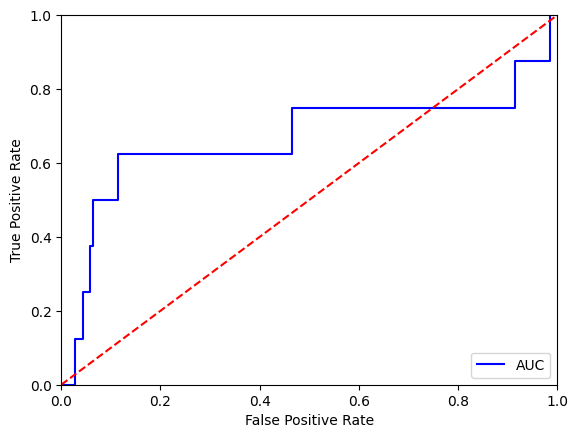

In [37]:
results = {}
# Collects performance metrics for all tasks on test set
for i in range(len(clintox_task)):
    
    valid_datapoints = y_test[:,i] >= 0
    y_test_task = y_test[valid_datapoints,i] 
    y_test_pred_task = y_test_pred[i].detach().numpy()[valid_datapoints,0]
    
    acc = accuracy_score(y_test_task, np.round(y_test_pred_task))
    print('Accuracy for STDNN on Morgan Fingerprint:', acc)
    
    bacc = sklearn.metrics.balanced_accuracy_score(y_test_task, np.round(y_test_pred_task))
    print('Balanced Accuracy for STDNN on Morgan Fingerprint:', bacc)

    f1 = f1_score(y_test_task, np.round(y_test_pred_task), pos_label=1)
    print('F1 for STDNN on Morgan Fingerprint:', f1)

    cfm = sklearn.metrics.confusion_matrix(y_test_task, np.round(y_test_pred_task))
    cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
    
    tn, fp, fn, tp = cfm.ravel()
    pr = tp / (tp + fp)
    rc = tp / (tp + fn)
    print(' True Positive:', tp)
    print(' True Negative:', tn)
    print('False Positive:', fp)
    print('False Negative:', fn)
    
    
    auc = roc_auc_score(y_test_task, y_test_pred_task)
    print('Test ROC AUC ({}):'.format(clintox_task[i]), auc)
    
    results[clintox_task[i]] = [auc, acc, bacc, tn, tp, pr, rc, f1]

    fpr, tpr, threshold = sklearn.metrics.roc_curve(y_test_task, y_test_pred_task)
    plt.plot(fpr, tpr, 'b', label = 'AUC')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Here we have the same results obtained by the reference paper using their model and data splits.

We'll try to improve the performances using the same data splits.

#### Deep Purpose

In [38]:
# Function to evaluate the model 
def evaluate_model(model, test):
    # Get labels and predictions from DataFrame
    y_true = np.array(test['Label'])
    y_pred = np.array(model.predict(test))

    # Convert continuous targets to binary targets using a threshold of 0.5
    y_true_binary = (y_true > 0.5).astype(int)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate evaluation metrics on binary targets
    accuracy = accuracy_score(y_true_binary, y_pred_binary)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    conf_mat = confusion_matrix(y_true_binary, y_pred_binary)
    bacc = balanced_accuracy_score(y_true_binary, y_pred_binary)


    # Create a list of metric names and values
    metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC", "Balanced Accuracy"]
    values = [accuracy, precision, recall, f1, roc_auc, bacc]

    # Create a list of lists for tabulating
    table = [metrics, values]

    # Display the table
    print(tabulate(table, headers='firstrow'))


    # Create a heatmap of the confusion matrix
    sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])

    # Add labels and title
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()

In [39]:
# Get X and y for train, test, val splits
X_train = train_data['smiles']
y_train = train_data['CT_TOX']

X_test = test_data['smiles']
y_test = test_data['CT_TOX']

X_valid = valid_data['smiles']
y_valid = valid_data['CT_TOX']

In [40]:
def train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, drug_encoding='Morgan'):
    # Get fingerprints for train, test, val splits
    train = utils.data_process(X_drug = X_train, y = y_train, drug_encoding = drug_encoding, split_method='no_split', random_seed = SEED_VALUE)
    val = utils.data_process(X_drug = X_valid, y = y_valid, drug_encoding = drug_encoding, split_method='no_split', random_seed = SEED_VALUE)
    test = utils.data_process(X_drug = X_test, y = y_test, drug_encoding = drug_encoding, split_method='no_split', random_seed = SEED_VALUE)


    # Configuring the model 
    config = utils.generate_config(drug_encoding = drug_encoding, 
                            mlp_hidden_dims_drug = [32, 16, 8], 
                            train_epoch = 40, 
                            LR = 0.001, 
                            batch_size = 124,
                            )

    model_dp = CompoundPred.model_initialize(**config)

    
    # Training the model 
    print('\n\n', '-'*30)
    print(f'Model training using {drug_encoding} fingerprint:')
    model_dp.train(train, val, test, verbose=1)

    # Evaluating the model
    evaluate_model(model_dp, test)
    print('-'*30)

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Morgan fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67594. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.52292 , AUPRC: 0.12658 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.25854. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.61886 , AUPRC: 0.21123 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.32405. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.60660 , AUPRC: 0.

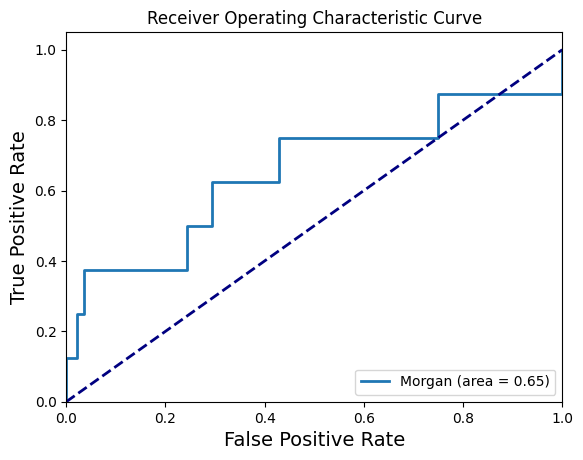

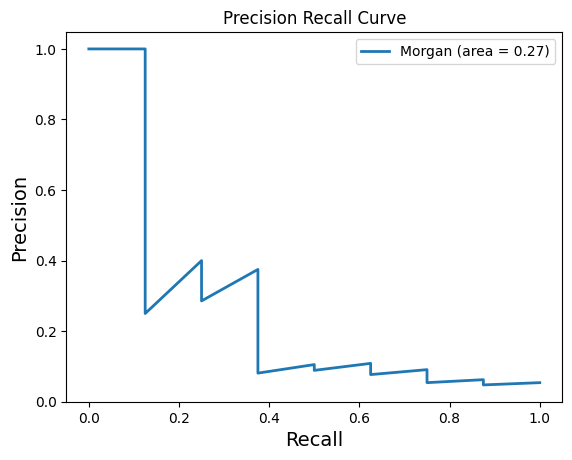

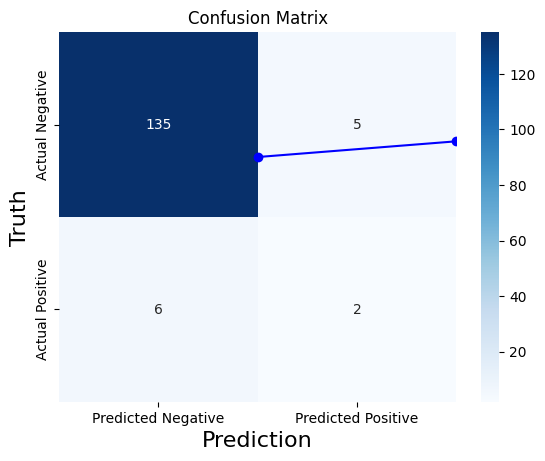

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Pubchem fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68584. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.64658 , AUPRC: 0.18823 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.31598. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.66204 , AUPRC: 0.23644 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.26038. Total time 0.0 hours
Validation at Epoc

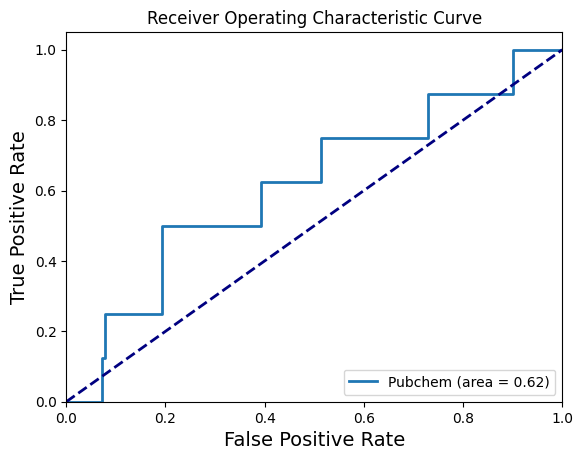

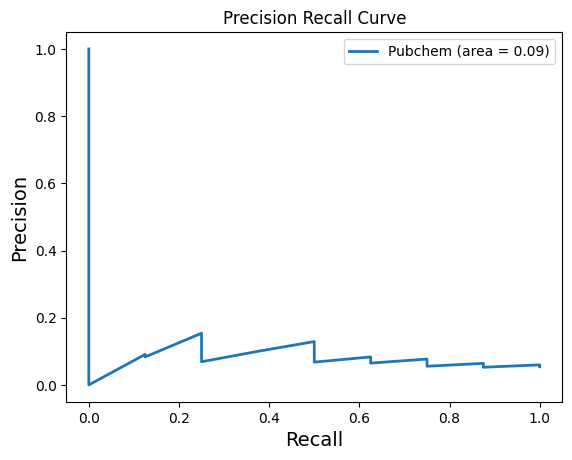

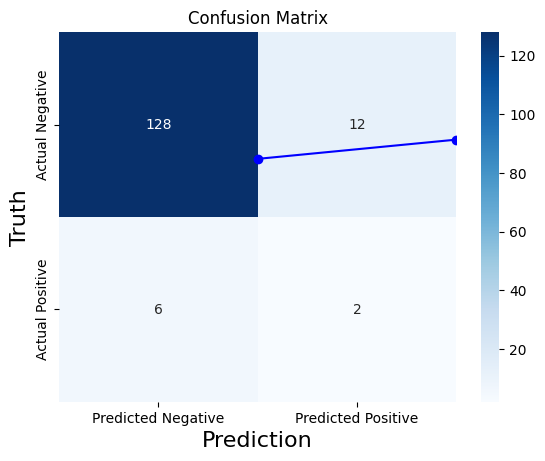

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
rdkit not found this smiles: [Se] convert to all 0 features
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Daylight fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.71121. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.60447 , AUPRC: 0.12009 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.21078. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.65405 , AUPRC: 0.13990 , F1: 0.0
Training at Epoch 3 iteration

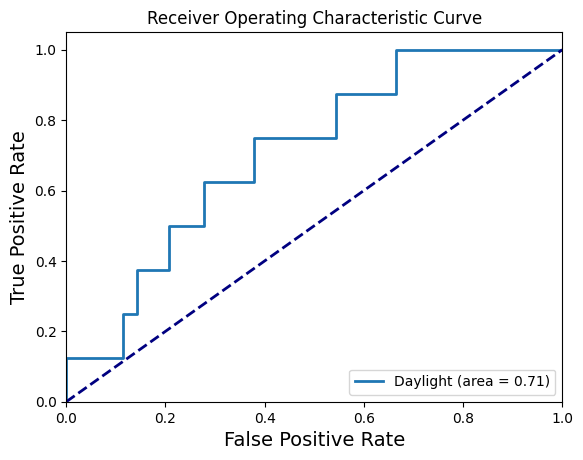

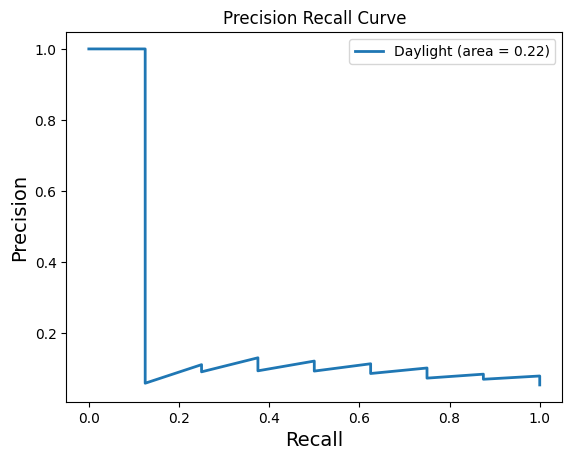

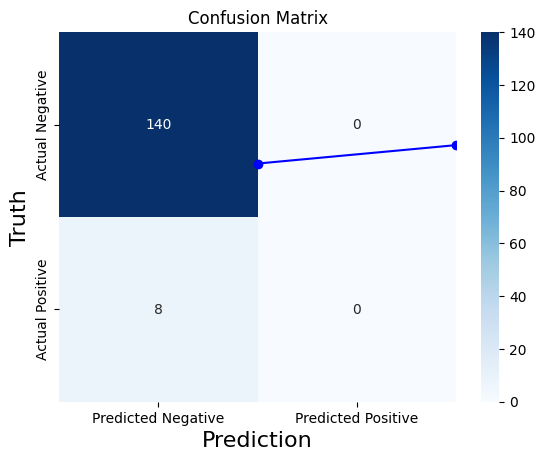

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using rdkit_2d_normalized fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68705. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.59434 , AUPRC: 0.13527 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.26411. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.76652 , AUPRC: 0.31426 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.21720. Total time 0.0 hours
Valida

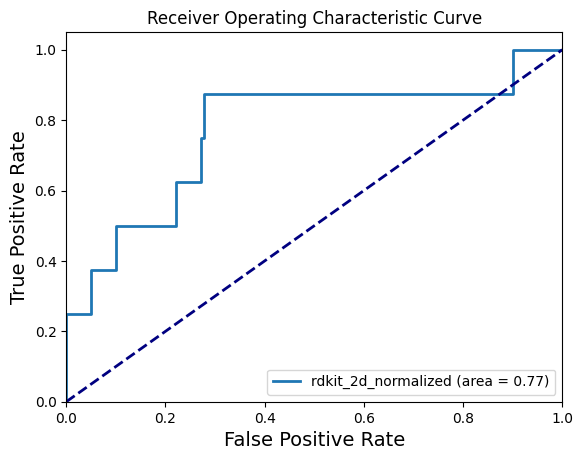

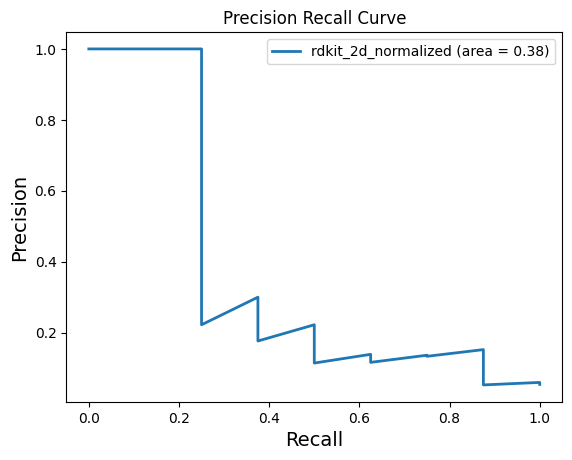

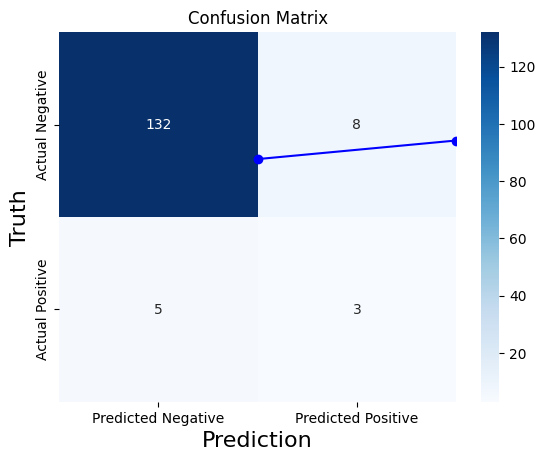

------------------------------


[None, None, None, None]

In [41]:
# Test DeepPurpode models using different drug encodings (seen in class)
drug_encodings = ['Morgan', 'Pubchem', 'Daylight', 'rdkit_2d_normalized']

[train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, encoding) for encoding in drug_encodings]

The best fingerprint, between the ones seen in class, in general seems to be Morgan fingerprint

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ESPF fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68528. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.95628 , AUPRC: 0.78517 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.29781. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.95575 , AUPRC: 0.89339 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.19046. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.96855 , AUPRC: 0.90

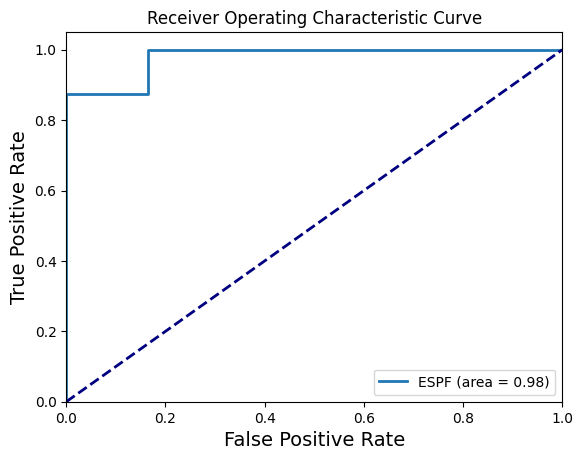

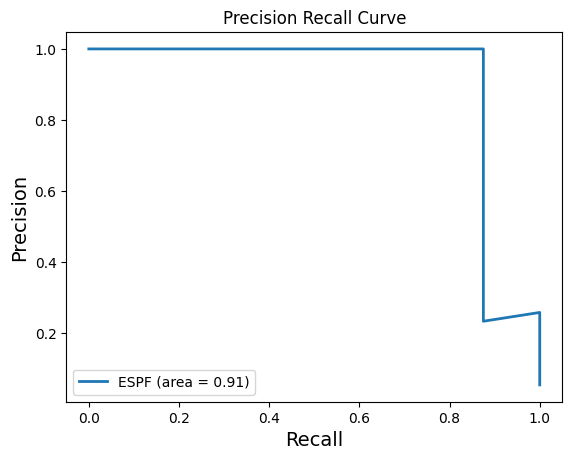

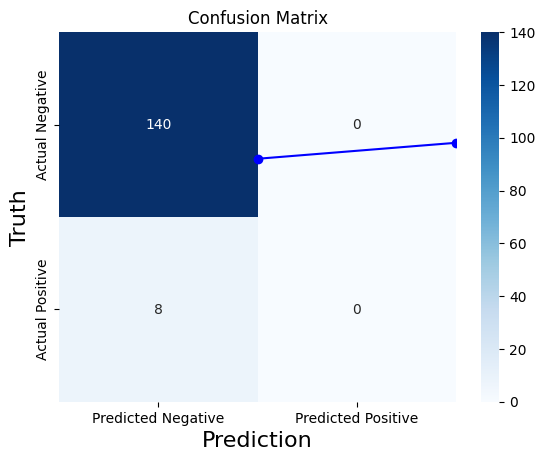

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ErG fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68303. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.49999 , AUPRC: 0.23296 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.19514. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.76119 , AUPRC: 0.38225 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.29071. Total time 0.0 hours
Validation at Epoch 3 

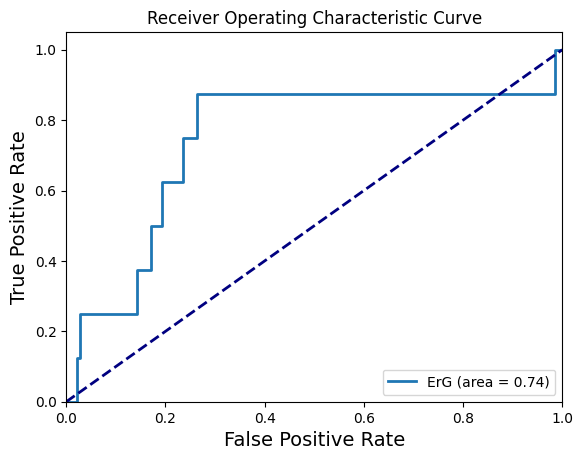

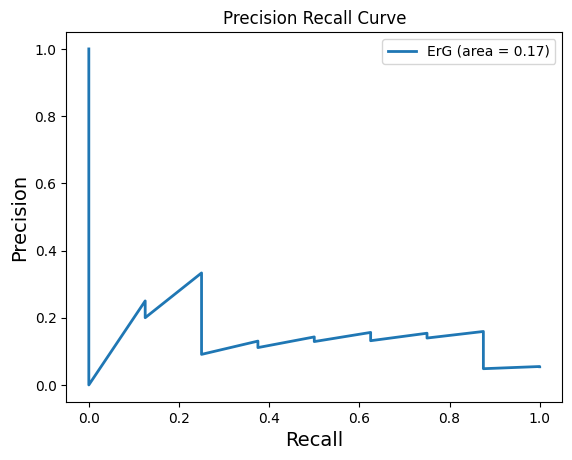

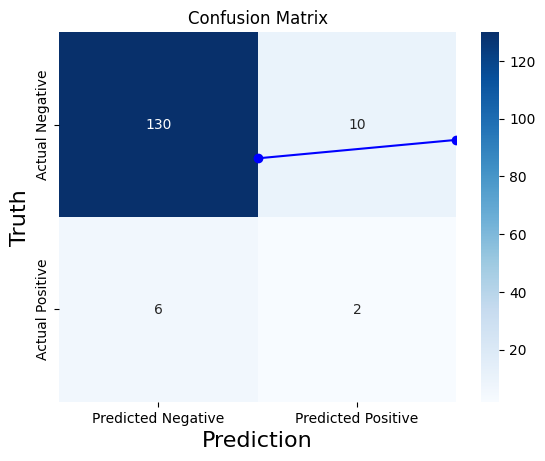

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68525. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.75639 , AUPRC: 0.18887 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.33907. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.93496 , AUPRC: 0.53723 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.37785. Total time 0.00083 hours
Validation at 

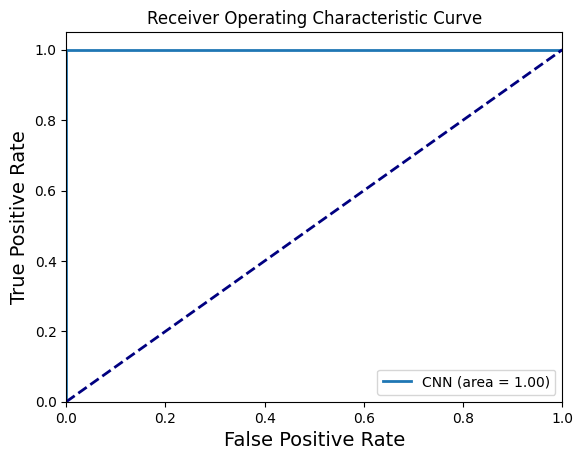

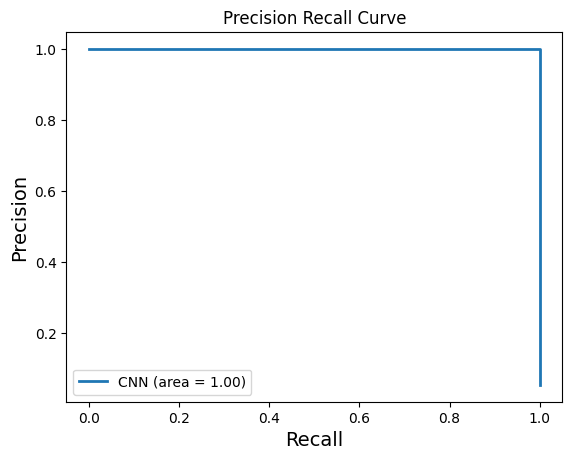

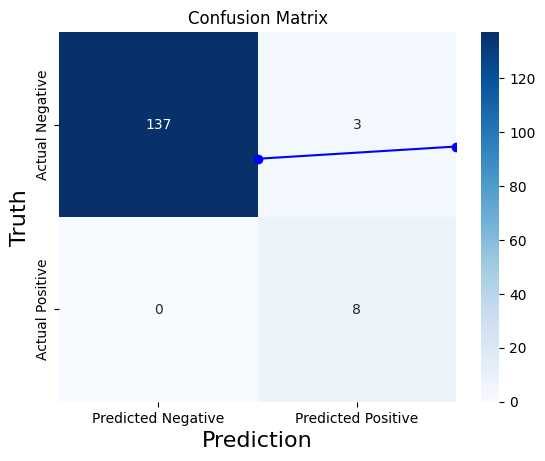

------------------------------


[None, None, None]

In [42]:
# Test DeepPurpode models using different drug encodings (not seen in class)
drug_encodings = ['ESPF', 'ErG', 'CNN', 'Transformer']

[train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, encoding) for encoding in drug_encodings]

ESPF and CNN drug encodings work really well, with the CNN drug encoding working incredibly well!

We reached scores very close to the best ones reported in the reference paper but without adding any feature and using just data from Clintox dataset.

The Transformer drug encoding seems to be so complex that it just overfits the training data.

##### Add Features from RDkit

In [43]:
# Split data into training, testing and valuidation sets
train_data = clintox_df[0]
test_data  = clintox_df[1]
valid_data = clintox_df[2]

In [44]:
#Calculating LogP, MW, RB, AromaticAtoms, HeavyAtoms, AP  descriptors
def compute_descriptors(df):
    dfc = df.copy()
    dfc["ROMol"] = dfc["smiles"].apply(lambda x: Chem.MolFromSmiles(x))
    dfc['MolLogP'] = [Descriptors.MolLogP(mol) for mol in dfc['ROMol']]
    dfc['RB'] =  [Descriptors.NumRotatableBonds(mol) for mol in dfc['ROMol']]
    dfc['cLogP'] = [Descriptors.MolWt(mol) for mol in dfc['ROMol']]
    dfc['ExactMolWt'] = [Descriptors.ExactMolWt(mol) for mol in dfc['ROMol']]
    dfc['NumRotatableBonds'] = [Descriptors.NumRotatableBonds(mol) for mol in dfc['ROMol']]
    dfc['MolWt'] = [Descriptors.MolWt(mol) for mol in dfc['ROMol']]
    dfc['AromaticAtoms'] = [len(mol.GetAromaticAtoms()) for mol in dfc['ROMol']]
    dfc['HeavyAtoms'] = [mol.GetNumHeavyAtoms() for mol in dfc['ROMol']]
    dfc['AP'] = dfc['AromaticAtoms'] / dfc['HeavyAtoms']
    
    return dfc

In [45]:
# Compute features on the already splitted data
train_features, test_features, valid_features = [compute_descriptors(data) for data in [train_data, test_data, valid_data]]

In [46]:
# Check the sets with the new features
train_features.head(3)

,smiles,FDA_APPROVED,CT_TOX,ROMol,MolLogP,RB,cLogP,ExactMolWt,NumRotatableBonds,MolWt,AromaticAtoms,HeavyAtoms,AP
755,CC(C)CN(C[C@H]([C@H](Cc1ccccc1)NC(=O)O[C@H]2CC...,1,0,<rdkit.Chem.rdchem.Mol object at 0x0000029B98B...,2.40280,11,505.637,505.224657,11,505.637,12,35,0.342857
96,C1[C@H](C(=O)NO1)[NH3+],1,0,<rdkit.Chem.rdchem.Mol object at 0x0000029B98B...,-2.34170,0,103.101,103.050204,0,103.101,0,7,0.000000
671,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,0,1,<rdkit.Chem.rdchem.Mol object at 0x0000029B98C...,5.89378,3,469.548,469.190260,3,469.548,29,36,0.805556


In [89]:
# Get X and y for train, test, val splits
X_train = train_features[['smiles', 'FDA_APPROVED', 'ROMol', 'MolLogP', 'RB', 'cLogP',
                         'ExactMolWt', 'NumRotatableBonds', 'MolWt', 'AromaticAtoms',
                         'HeavyAtoms', 'AP']]
y_train = train_features['CT_TOX']

X_test = test_features[['smiles', 'FDA_APPROVED', 'ROMol', 'MolLogP', 'RB', 'cLogP',
                         'ExactMolWt', 'NumRotatableBonds', 'MolWt', 'AromaticAtoms',
                         'HeavyAtoms', 'AP']]
y_test = test_features['CT_TOX']

X_valid = valid_features[['smiles', 'FDA_APPROVED', 'ROMol', 'MolLogP', 'RB', 'cLogP',
                         'ExactMolWt', 'NumRotatableBonds', 'MolWt', 'AromaticAtoms',
                         'HeavyAtoms', 'AP']]
y_valid = valid_features['CT_TOX']

In [90]:
# Concatenate the features to make them compatible with DeepPurpose
X_train = np.concatenate([X_train['smiles']] + [X_train.drop(['smiles', 'ROMol'], axis=1).values.flatten()], axis=0)
X_test = np.concatenate([X_test['smiles']] + [X_test.drop(['smiles', 'ROMol'], axis=1).values.flatten()], axis=0)
X_valid = np.concatenate([X_valid['smiles']] + [X_valid.drop(['smiles', 'ROMol'], axis=1).values.flatten()], axis=0)

Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Morgan fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69971. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.52665 , AUPRC: 0.16039 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.22328. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.59594 , AUPRC: 0.20188 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.26208. Total time 0.0 hours
Validation at Epoch 3 , AUROC: 0.63965 , AUPRC: 0.

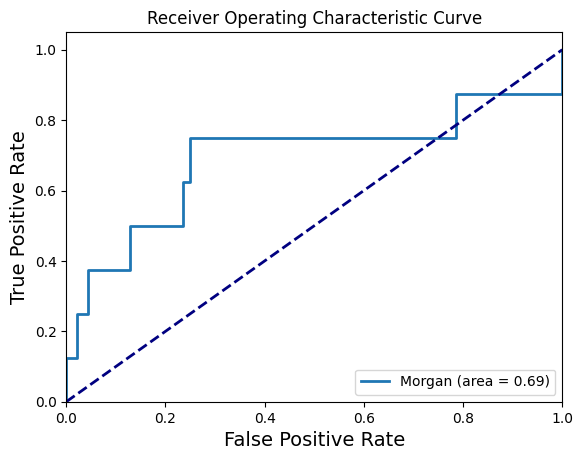

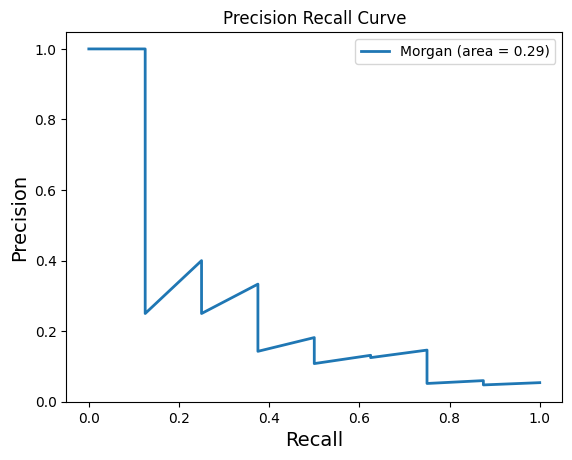

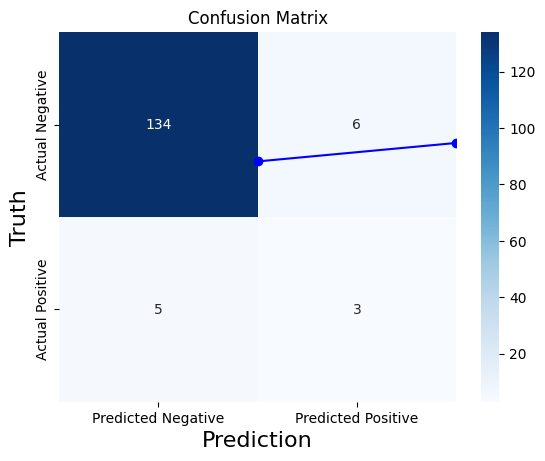

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Pubchem fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68101. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.64872 , AUPRC: 0.15518 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.37650. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.61300 , AUPRC: 0.12446 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.23140. Total time 0.0 hours
Validation at Epoc

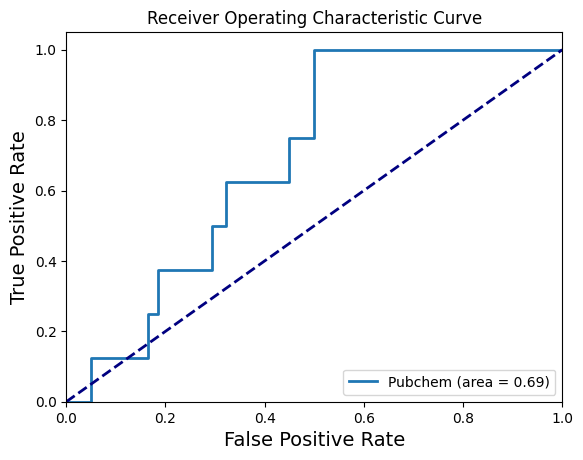

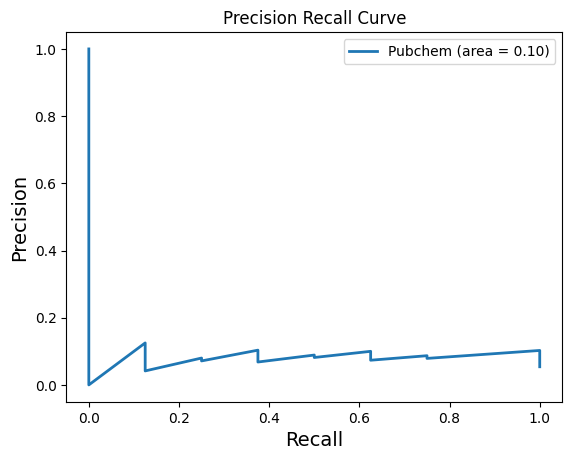

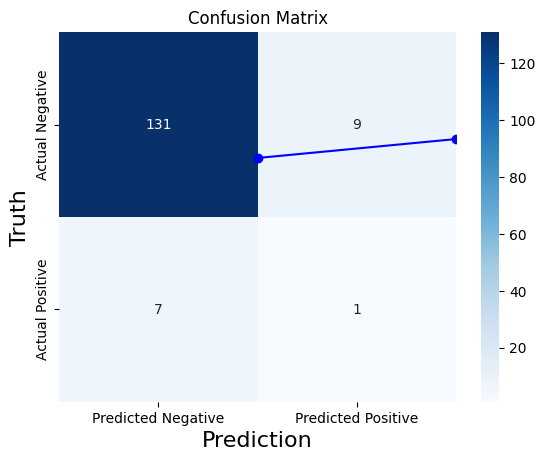

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
rdkit not found this smiles: [Se] convert to all 0 features
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Daylight fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69028. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.63752 , AUPRC: 0.13087 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.40364. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.69669 , AUPRC: 0.17902 , F1: 0.0
Training at Epoch 3 iteration

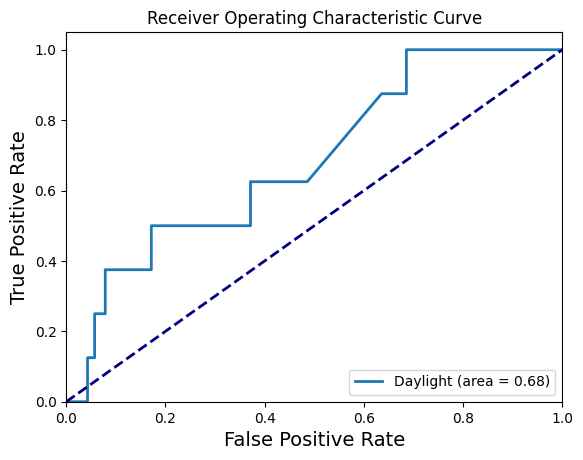

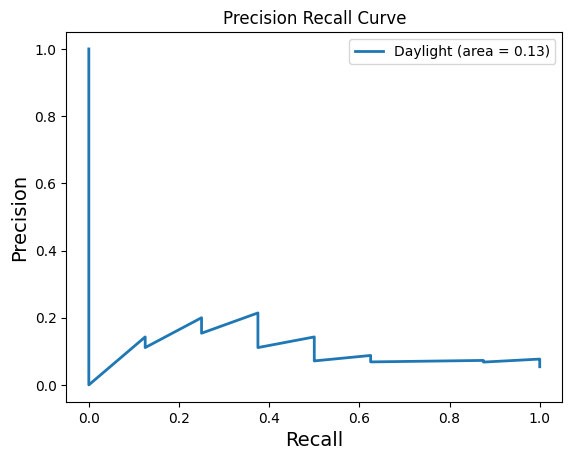

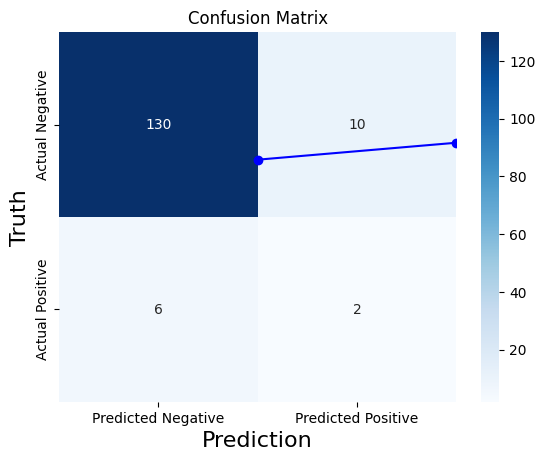

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using rdkit_2d_normalized fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.68274. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.68070 , AUPRC: 0.22937 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.23854. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.62420 , AUPRC: 0.26332 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.14518. Total time 0.0 hours
Valida

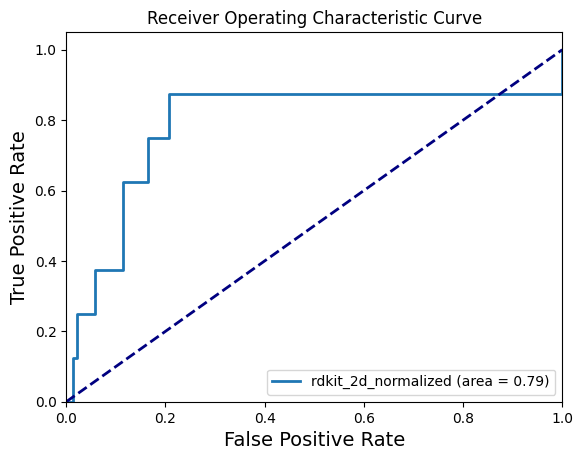

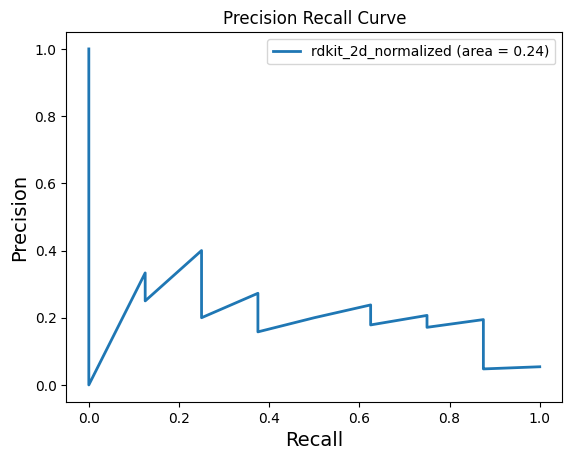

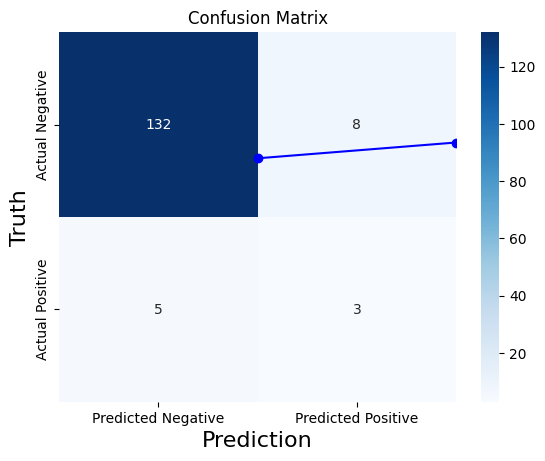

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ESPF fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69507. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.91204 , AUPRC: 0.81984 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.17076. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.93336 , AUPRC: 0.88311 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.30283. Total time 0.0 hours
Validation at Epoch 3

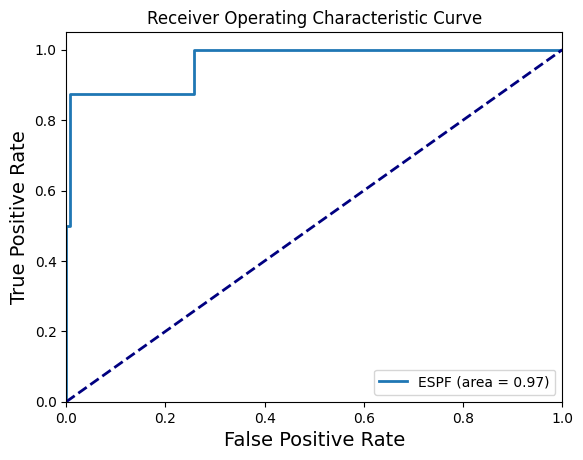

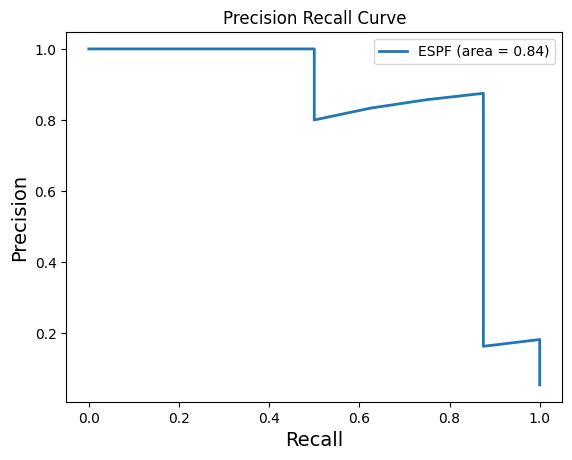

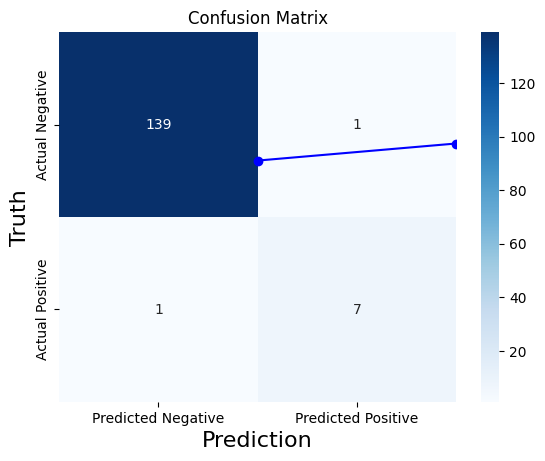

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using ErG fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67379. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.66204 , AUPRC: 0.15069 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.20156. Total time 0.0 hours
Validation at Epoch 2 , AUROC: 0.69029 , AUPRC: 0.22473 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.27548. Total time 0.0 hours
Validation at Epoch 3 

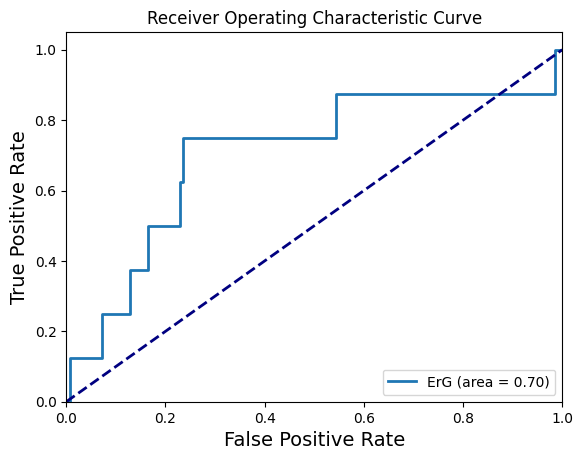

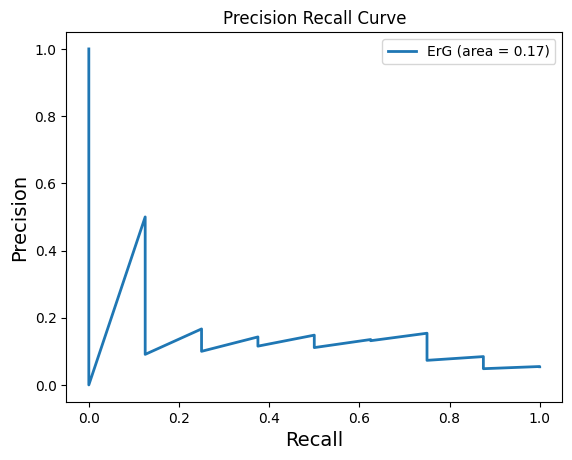

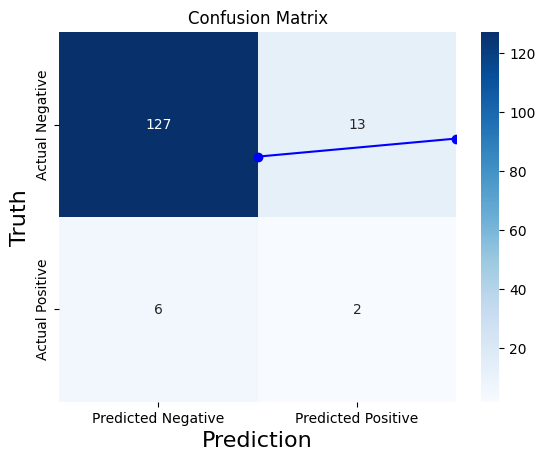

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using CNN fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.67785. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.87100 , AUPRC: 0.28097 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.27824. Total time 0.00055 hours
Validation at Epoch 2 , AUROC: 0.91577 , AUPRC: 0.37428 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.32866. Total time 0.00111 hours
Validation at 

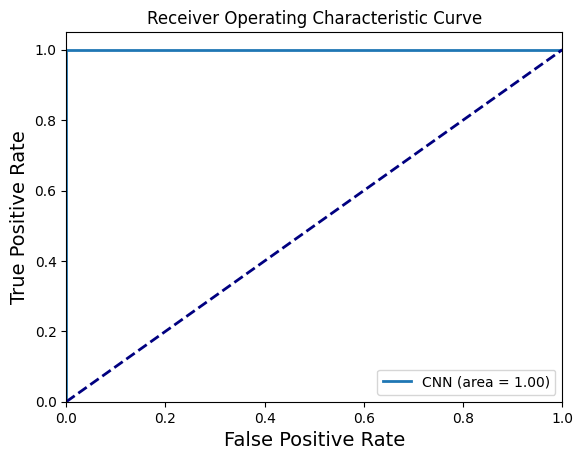

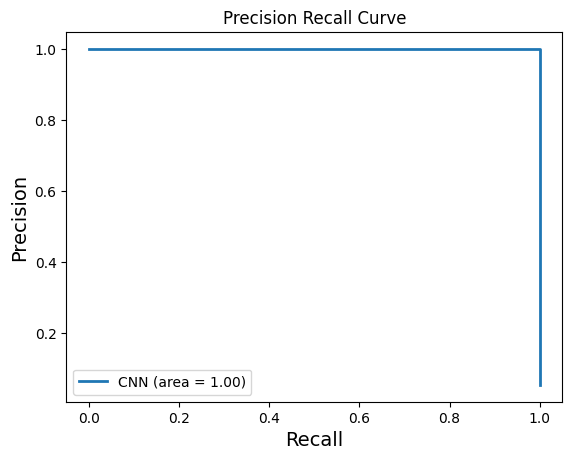

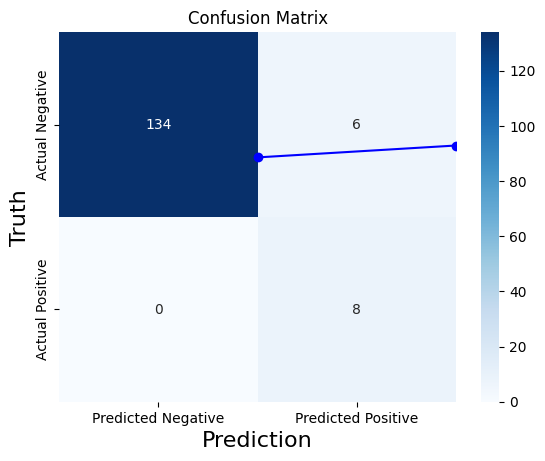

------------------------------
Drug Property Prediction Mode...
in total: 1182 drugs
encoding drug...
unique drugs: 1182
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 148 drugs
encoding drug...
unique drugs: 148
do not do train/test split on the data for already splitted data


 ------------------------------
Model training using Transformer fingerprint:
Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.70233. Total time 0.00027 hours
Validation at Epoch 1 , AUROC: 0.44029 , AUPRC: 0.08485 , F1: 0.0
Training at Epoch 2 iteration 0 with loss 0.25886. Total time 0.00472 hours
Validation at Epoch 2 , AUROC: 0.44136 , AUPRC: 0.10592 , F1: 0.0
Training at Epoch 3 iteration 0 with loss 0.26848. Total time 0.00916 hours
Va

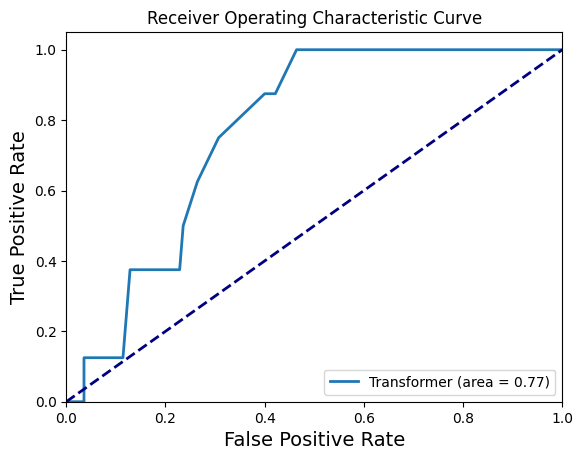

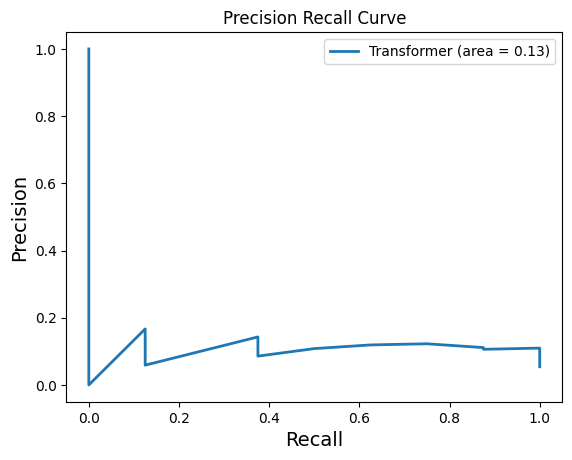

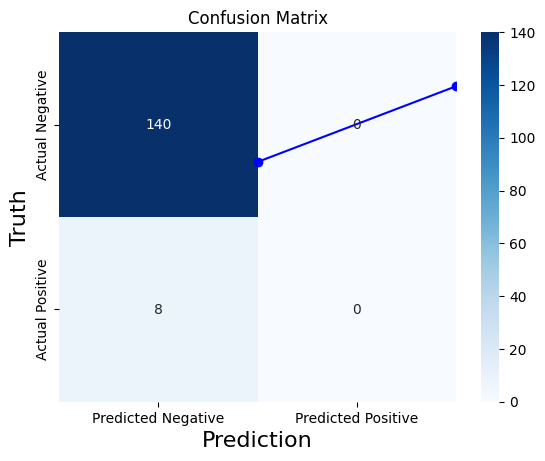

------------------------------


[None, None, None, None, None, None, None, None]

In [93]:
# Train the DeepPurpose model using all the new features
drug_encodings = ['Morgan', 'Pubchem', 'Daylight', 'rdkit_2d_normalized', 'ESPF', 'ErG', 'CNN', 'Transformer']

[train_model(X_train, y_train, X_test, y_test, X_valid, y_valid, encoding) for encoding in drug_encodings]

As seen in the test with the models using just smiles as features, the best drug encodings seem to be ESPF and CNN, with CNN as the best one.

It seems that adding these features didn't improve the results.

We'll try to perform feature selection to see if we can remove some confounder features and improve the results obtained just from using the smiles.

##### Features Selection

In [ ]:
# Try feature selection stuff


##### Hyper-parameters Tuning

#### Test Graph Neural Networks

### Using Tox21 data